# Developing an AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories, you can see a few examples below. 

<img src='assets/Flowers.png' width=500px>

The project is broken down into multiple steps:

* Load and preprocess the image dataset
* Train the image classifier on your dataset
* Use the trained classifier to predict image content

We'll lead you through each part which you'll implement in Python.

When you've completed this project, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about flowers and end up as a command line application. But, what you do with your new skills depends on your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it. Go build your own dataset and make something new.

First up is importing the packages you'll need. It's good practice to keep all the imports at the beginning of your code. As you work through this notebook and find you need to import a package, make sure to add the import up here.

In [1]:
# Imports here

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

import torch
from torchvision import datasets, transforms
from torch.utils.data.dataset import Dataset
from torch.utils.data.sampler import SubsetRandomSampler

import numpy as np
import pandas as pd
from PIL import Image
import glob
import os
import time

In [2]:
torch.cuda.empty_cache()

## Load the data

Here you'll use `torchvision` to load the data ([documentation](http://pytorch.org/docs/0.3.0/torchvision/index.html)). You can [download the data here](https://s3.amazonaws.com/content.udacity-data.com/courses/nd188/flower_data.zip). The dataset is split into two parts, training and validation. For the training, you'll want to apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. If you use a pre-trained network, you'll also need to make sure the input data is resized to 224x224 pixels as required by the networks.

The validation set is used to measure the model's performance on data it hasn't seen yet. For this you don't want any scaling or rotation transformations, but you'll need to resize then crop the images to the appropriate size.

The pre-trained networks available from `torchvision` were trained on the ImageNet dataset where each color channel was normalized separately. For both sets you'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.

In [3]:
data_dir = 'flower_data'
train_dir = data_dir + '/train/'
valid_dir = data_dir + '/valid/'
test_dir = data_dir + '/test/'

In [4]:
# TODO: Define your transforms for the training and validation sets
data_transforms = transforms.Compose([transforms.Resize(500),
                    transforms.CenterCrop(500),
                    transforms.RandomHorizontalFlip(), # randomly flip and rotate
                    transforms.RandomRotation(10),
                    transforms.ToTensor(),
                    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))                    
                    ])
# (0.485, 0.456, 0.406), (0.229, 0.224, 0.225)
# (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)
# transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))

# TODO: Load the datasets with ImageFolder
train_image_datasets = datasets.ImageFolder(train_dir, transform=data_transforms)

valid_image_datasets = datasets.ImageFolder(valid_dir, transform=data_transforms)

In [5]:
train_image_datasets

Dataset ImageFolder
    Number of datapoints: 6552
    Root Location: flower_data/train/
    Transforms (if any): Compose(
                             Resize(size=500, interpolation=PIL.Image.BILINEAR)
                             CenterCrop(size=(500, 500))
                             RandomHorizontalFlip(p=0.5)
                             RandomRotation(degrees=(-10, 10), resample=False, expand=False)
                             ToTensor()
                             Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
                         )
    Target Transforms (if any): None

In [6]:
# train_image_datasets = torch.utils.data.ConcatDataset([train_image_datasets,random_dataset])

In [7]:
# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 10

In [8]:
# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_image_datasets, batch_size=batch_size, num_workers=num_workers, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_image_datasets, batch_size=batch_size, num_workers=num_workers, shuffle=True)

In [9]:
len(train_loader)

656

### Label mapping

You'll also need to load in a mapping from category label to category name. You can find this in the file `cat_to_name.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/2/library/json.html). This will give you a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [10]:
import json

with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

In [11]:
# cat_to_name
# cat_to_name['105'] = "Noise"

In [12]:
# helper function to un-normalize and display an image

def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


3
36
78
81
41


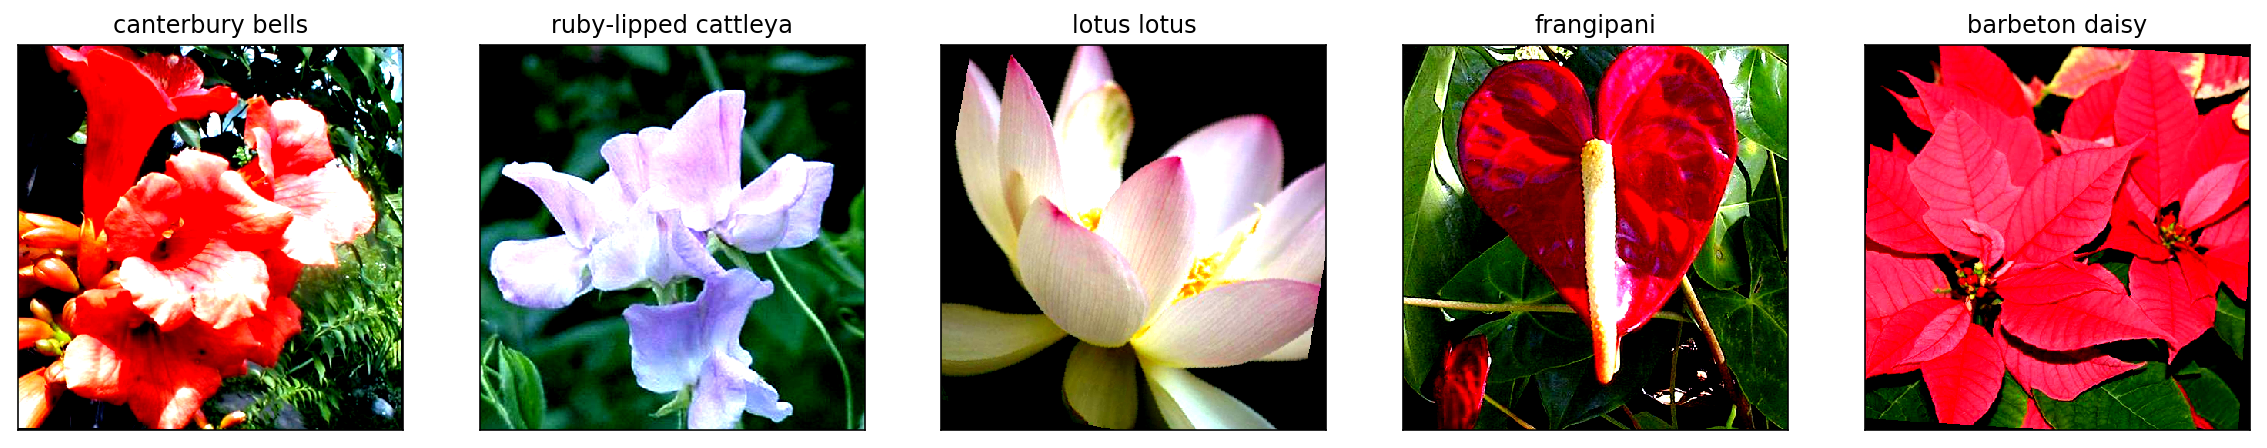

In [13]:
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display
labels = labels.numpy()

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 5))


# display 20 images
for idx in np.arange(5):
    print(labels[idx])
          
#     change tensor type to string type
#     print(labels[idx])
#     scalar_lable = int(labels[idx+1])
#     print(type(scalar_lable))
#     print(scalar_lable)
#     str_label = str(scalar_lable)
#     print(cat_to_name[str_label])
#     break

    ax = fig.add_subplot(1, 5, idx+1, xticks=[], yticks=[])
#     print(images[idx])
    imshow(images[idx])
    
    ax.set_title(cat_to_name[str(int(labels[idx]))])

# Building and training the classifier

Now that the data is ready, it's time to build and train the classifier. As usual, you should use one of the pretrained models from `torchvision.models` to get the image features. Build and train a new feed-forward classifier using those features.

We're going to leave this part up to you. If you want to talk through it with someone, chat with your fellow students! You can also ask questions on the forums or join the instructors in office hours.

Refer to [the rubric](https://review.udacity.com/#!/rubrics/1663/view) for guidance on successfully completing this section. Things you'll need to do:

* Load a [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html) (If you need a starting point, the VGG networks work great and are straightforward to use)
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters

We've left a cell open for you below, but use as many as you need. Our advice is to break the problem up into smaller parts you can run separately. Check that each part is doing what you expect, then move on to the next. You'll likely find that as you work through each part, you'll need to go back and modify your previous code. This is totally normal!

When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right. Make sure to try different hyperparameters (learning rate, units in the classifier, epochs, etc) to find the best model. Save those hyperparameters to use as default values in the next part of the project.

In [14]:
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [15]:
# TODO: Build and train your network
import torch.nn as nn
import torch.nn.functional as F

# define the CNN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv4 = nn.Conv2d(64, 64, 3, padding=1)
        self.conv5 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv6 = nn.Conv2d(128, 128, 3, padding=1)


        self.pool = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(128 * 7 * 7, 512)
        self.fc2 = nn.Linear(512, 102)

        self.dropout = nn.Dropout(0.25)

    def forward(self, x):

        x = self.pool(F.relu(self.conv1(x)))
        x = self.dropout(x)
        x = self.pool(F.relu(self.conv2(x)))
        x = self.dropout(x)        
        x = self.pool(F.relu(self.conv3(x)))
        x = self.dropout(x)
        x = self.pool(F.relu(self.conv4(x)))
        x = self.dropout(x)
        x = self.pool(F.relu(self.conv5(x)))
        x = self.dropout(x)
        x = self.pool(F.relu(self.conv6(x)))
        x = self.dropout(x)

        x = x.view(-1, 128 * 7 * 7)

        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        return x

# create a complete CNN
model = Net()
print(model)

# move tensors to GPU if CUDA is available
if train_on_gpu:
    torch.cuda.empty_cache()
    model.cuda()

Net(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=6272, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=102, bias=True)
  (dropout): Dropout(p=0.25)
)


In [16]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001, amsgrad=True, eps=1e-8, weight_decay=1e-5 )

In [17]:

array_train_loss = []
array_valid_loss = []
array_train_acc = []
array_valid_acc = []

# number of epochs to train the model
n_epochs = 100

valid_loss_min = np.Inf # track change in validation loss

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    nums_train_correct = 0
    nums_valid_correct = 0
    
    ###################
    # train the model #
    ###################
    model.train()
    start = time.time()
    
    for batch_index, (data, target) in enumerate(train_loader):
#         print("-------------------train---------------------")
#         print(data.size())
#         print(target)
        
#         start_batch = time.time()

        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        
        # (train)forward pass: compute predicted outputs by passing inputs to the model        
        output = model(data)
        
#         print(output)
        
        # calculate the batch loss
        loss = criterion(output, target)
        
        _, preds = torch.max(output, 1)
        
        
        # update average validation loss 
        nums_train_correct += torch.sum(preds == target.data)

        
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        
        # perform a single optimization step (parameter update)
        optimizer.step()
        
        # update training loss
        train_loss += loss.item()*data.size(0)

#         print('{} batch: train loss {} '.format( batch_index+1,loss.item()*data.size(0)/batch_size))


    ######################    
    # validate the model #
    ######################
    model.eval()
    for data, target in valid_loader:
        
#         print("-------------------validate----------------------")
#         print(len(data))
#         print(target)
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
            
        # (validation)forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        _, preds = torch.max(output, 1)
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)
        nums_valid_correct += torch.sum(preds == target.data)

#         print('{} batch: valid loss {} '.format( batch_index+1,loss.item()*data.size(0)/batch_size))
        
    # calculate average losses
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(valid_loader.dataset)
    valid_acc = nums_valid_correct.double() / len(valid_loader.dataset)
    train_acc = nums_train_correct.double() / len(train_loader.dataset)

    array_train_loss.append(train_loss)
    array_valid_loss.append(valid_loss)
    array_train_acc.append(train_acc)
    array_valid_acc.append(valid_acc)
    
    
    # print training/validation statistics 
    print('Epoch: {} \tTrain Loss: {:.6f} \tVal Loss: {:.6f} \tTrain Acc: {:.2f} \tVal Acc: {:.2f}'.format(
        epoch, train_loss, valid_loss,  train_acc*100, valid_acc*100))
    
    state = {'epoch': epoch + 1, 
             'state_dict': model.state_dict(),
             'optimizer': optimizer.state_dict()}
    torch.save(state, './models/model_flower_v9_checkpoint.pth.tar')
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model_flower_v9.pt')
        valid_loss_min = valid_loss

    print('{} epoc costs {:.2f} seconds'.format( epoch,time.time() - start))

Epoch: 1 	Train Loss: 4.256014 	Val Loss: 4.111942 	Train Acc: 4.67 	Val Acc: 9.05
Validation loss decreased (inf --> 4.111942).  Saving model ...
1 epoc costs 207.03 seconds
Epoch: 2 	Train Loss: 3.497476 	Val Loss: 3.434331 	Train Acc: 14.87 	Val Acc: 20.90
Validation loss decreased (4.111942 --> 3.434331).  Saving model ...
2 epoc costs 206.37 seconds
Epoch: 3 	Train Loss: 2.890815 	Val Loss: 2.977975 	Train Acc: 25.84 	Val Acc: 30.32
Validation loss decreased (3.434331 --> 2.977975).  Saving model ...
3 epoc costs 205.72 seconds
Epoch: 4 	Train Loss: 2.505451 	Val Loss: 2.668907 	Train Acc: 34.31 	Val Acc: 35.33
Validation loss decreased (2.977975 --> 2.668907).  Saving model ...
4 epoc costs 203.86 seconds
Epoch: 5 	Train Loss: 2.195529 	Val Loss: 2.514648 	Train Acc: 41.36 	Val Acc: 37.16
Validation loss decreased (2.668907 --> 2.514648).  Saving model ...
5 epoc costs 209.90 seconds
Epoch: 6 	Train Loss: 1.956378 	Val Loss: 2.272836 	Train Acc: 47.24 	Val Acc: 42.42
Validation l

KeyboardInterrupt: 

In [18]:
array_train_loss

[4.256014186602372,
 3.4974755529810073,
 2.8908152657405215,
 2.505451166331404,
 2.19552920409393,
 1.9563777343221054,
 1.750066314197358,
 1.5450990154738828,
 1.3875913896549024,
 1.2328332463627334,
 1.0943351552681826,
 0.9802318577255521,
 0.8640530518141276,
 0.757956581041831,
 0.6684100179440059,
 0.6044521714669854,
 0.542533822731207,
 0.4716377074081708,
 0.41746805089932976,
 0.38061235749497624,
 0.3424983672390866,
 0.32465346526014544,
 0.2956455226479296,
 0.26314519769622635,
 0.2278356434040295,
 0.22834401548031594,
 0.2090129330463597,
 0.2141517777557825,
 0.1732915431893138,
 0.16735926734328554,
 0.16194291374107866,
 0.16380806816607854,
 0.14051188956591487]

In [19]:
array_valid_loss

[4.111942061585144,
 3.4343310515863097,
 2.9779747943132024,
 2.6689068676498526,
 2.51464807812334,
 2.272836112451437,
 2.190592008872837,
 2.212304757101903,
 2.0567478304387303,
 2.0328812584608866,
 1.972418743852881,
 2.0456528160857688,
 1.9517735362344382,
 1.9568164950478049,
 2.064233991219537,
 1.9816885054985875,
 1.9818843390364518,
 2.19334909935598,
 2.1716799862810334,
 2.2348144470479494,
 2.2281117846592715,
 2.211759204677964,
 2.2755351231267227,
 2.3586015265553386,
 2.4257528883903707,
 2.3799943008749294,
 2.55540861958105,
 2.5233725212368667,
 2.523425056182376,
 2.6103867633418525,
 2.5993407199610123,
 2.832078897646995,
 2.6533931579741408]

In [20]:
array_train_acc

[tensor(0.0467, device='cuda:0', dtype=torch.float64),
 tensor(0.1487, device='cuda:0', dtype=torch.float64),
 tensor(0.2584, device='cuda:0', dtype=torch.float64),
 tensor(0.3431, device='cuda:0', dtype=torch.float64),
 tensor(0.4136, device='cuda:0', dtype=torch.float64),
 tensor(0.4724, device='cuda:0', dtype=torch.float64),
 tensor(0.5176, device='cuda:0', dtype=torch.float64),
 tensor(0.5725, device='cuda:0', dtype=torch.float64),
 tensor(0.6134, device='cuda:0', dtype=torch.float64),
 tensor(0.6419, device='cuda:0', dtype=torch.float64),
 tensor(0.6819, device='cuda:0', dtype=torch.float64),
 tensor(0.7106, device='cuda:0', dtype=torch.float64),
 tensor(0.7396, device='cuda:0', dtype=torch.float64),
 tensor(0.7656, device='cuda:0', dtype=torch.float64),
 tensor(0.8007, device='cuda:0', dtype=torch.float64),
 tensor(0.8143, device='cuda:0', dtype=torch.float64),
 tensor(0.8268, device='cuda:0', dtype=torch.float64),
 tensor(0.8585, device='cuda:0', dtype=torch.float64),
 tensor(0.